мат модель

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import simpy

# Исходные данные
lambda1 = 3  # Высокоприоритетные заявки (заявок/час)
lambda2 = 5  # Низкоприоритетные заявки (заявок/час)
mu = 10      # Интенсивность обслуживания (заявок/час)

# Коэффициенты загрузки
rho1 = lambda1 / mu
rho2 = lambda2 / mu
rho = rho1 + rho2  # Общая загрузка системы

# Проверка устойчивости системы
assert rho < 1, "Система неустойчива (rho >= 1)"

# Среднее время ожидания в очереди (формулы для абсолютного приоритета)
Wq1 = rho / (mu * (1 - rho))  # Для высокоприоритетных
Wq2 = rho / (mu * (1 - rho)) + (lambda1 / mu) / (mu * (1 - rho))  # Для низкоприоритетных

# Среднее время пребывания в системе
W1 = Wq1 + 1/mu
W2 = Wq2 + 1/mu

# Вероятность ожидания в очереди (формула Erlang-C для M/M/1)
P_wait1 = rho
P_wait2 = rho

# Среднее число заявок в системе
L = rho / (1 - rho)

# Табличные результаты
results = {
    "Показатель": ["Среднее время ожидания (высок.)", "Среднее время ожидания (низк.)",
                   "Среднее время пребывания (высок.)", "Среднее время пребывания (низк.)",
                   "Вероятность ожидания (высок.)", "Вероятность ожидания (низк.)",
                   "Коэффициент загрузки", "Среднее число заявок в системе"],
    "Значение": [Wq1, Wq2, W1, W2, P_wait1, P_wait2, rho, L]
}

df_results = pd.DataFrame(results)
df_results["Значение"] = df_results["Значение"].apply(lambda x: round(x, 3))  # округлим до 3 знаков

print("Табличные результаты:")
print(df_results)


Табличные результаты:
                          Показатель  Значение
0    Среднее время ожидания (высок.)      0.40
1     Среднее время ожидания (низк.)      0.55
2  Среднее время пребывания (высок.)      0.50
3   Среднее время пребывания (низк.)      0.65
4      Вероятность ожидания (высок.)      0.80
5       Вероятность ожидания (низк.)      0.80
6               Коэффициент загрузки      0.80
7     Среднее число заявок в системе      4.00


Симуляция с использованием SimPy

In [19]:
# Симуляция работы системы с приоритетами
class CallCenter:
    def __init__(self, env):
        self.env = env
        self.operator = simpy.Resource(env, capacity=1)  # Один оператор
        self.vip_queue = []  # Очередь для высокоприоритетных
        self.regular_queue = []  # Очередь для низкоприоритетных
        self.waiting_times_vip = []  # Время ожидания высокоприоритетных
        self.waiting_times_regular = []  # Время ожидания низкоприоритетных
        self.total_times_vip = []  # Время пребывания высокоприоритетных
        self.total_times_regular = []  # Время пребывания низкоприоритетных

    def handle_call(self, caller_type, arrival_time):
        with self.operator.request() as request:
            yield request

            # время начала обслуживания
            wait_time = self.env.now - arrival_time

            # Статистика
            if caller_type == "vip":
                self.waiting_times_vip.append(wait_time)
            else:
                self.waiting_times_regular.append(wait_time)

            service_time = np.random.exponential(1 / mu)
            yield self.env.timeout(service_time)

            total_time = self.env.now - arrival_time
            if caller_type == "vip":
                self.total_times_vip.append(total_time)
            else:
                self.total_times_regular.append(total_time)

def vip_call_generator(env, center):
    while True:
        yield env.timeout(np.random.exponential(1 / lambda1))
        env.process(center.handle_call("vip", env.now))

def regular_call_generator(env, center):
    while True:
        yield env.timeout(np.random.exponential(1 / lambda2))
        env.process(center.handle_call("regular", env.now))

# Запуск симуляции
env = simpy.Environment()
center = CallCenter(env)
env.process(vip_call_generator(env, center))
env.process(regular_call_generator(env, center))
sim_time = 10000  # Время симуляции
env.run(until=sim_time)

# Средние значения
mean_wait_vip = np.mean(center.waiting_times_vip)
mean_wait_regular = np.mean(center.waiting_times_regular)
mean_total_vip = np.mean(center.total_times_vip)
mean_total_regular = np.mean(center.total_times_regular)

# Вывод результатов симуляции
print("=== РЕЗУЛЬТАТЫ СИМУЛЯЦИИ ===")
print(f"Среднее время ожидания (высок.): {mean_wait_vip:.3f}")
print(f"Среднее время ожидания (низк.): {mean_wait_regular:.3f}")
print(f"Среднее пребывание в системе (высок.): {mean_total_vip:.3f}")
print(f"Среднее пребывание в системе (низк.): {mean_total_regular:.3f}")

print("\n=== ТЕОРЕТИЧЕСКИЕ ЗНАЧЕНИЯ ===")
print(f"Среднее время ожидания (высок.): {Wq1:.3f}")
print(f"Среднее время ожидания (низк.): {Wq2:.3f}")
print(f"Среднее пребывание в системе (высок.): {W1:.3f}")
print(f"Среднее пребывание в системе (низк.): {W2:.3f}")


=== РЕЗУЛЬТАТЫ СИМУЛЯЦИИ ===
Среднее время ожидания (высок.): 0.386
Среднее время ожидания (низк.): 0.384
Среднее пребывание в системе (высок.): 0.486
Среднее пребывание в системе (низк.): 0.483

=== ТЕОРЕТИЧЕСКИЕ ЗНАЧЕНИЯ ===
Среднее время ожидания (высок.): 0.400
Среднее время ожидания (низк.): 0.550
Среднее пребывание в системе (высок.): 0.500
Среднее пребывание в системе (низк.): 0.650


Построение графика зависимости времени ожидания от интенсивности входящего потока

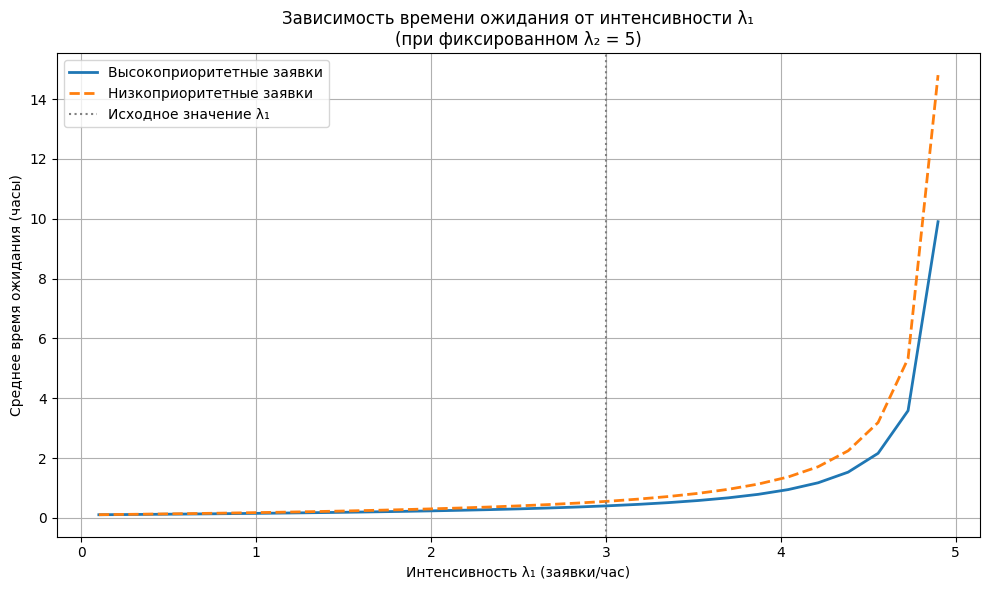

In [20]:
# Диапазоны входящих потоков
lambda1_range = np.linspace(0.1, 8.5, 50)
lambda2_fixed = 5
mu_fixed = 10

Wq1_values = []
Wq2_values = []

for lam1 in lambda1_range:
    rho_total = (lam1 + lambda2_fixed) / mu_fixed
    if rho_total >= 1:
        Wq1_values.append(np.nan)
        Wq2_values.append(np.nan)
        continue
    wq1 = rho_total / (mu_fixed * (1 - rho_total))
    wq2 = wq1 + (lam1 / mu_fixed) / (mu_fixed * (1 - rho_total))
    Wq1_values.append(wq1)
    Wq2_values.append(wq2)

plt.figure(figsize=(10, 6))
plt.plot(lambda1_range, Wq1_values, label="Высокоприоритетные заявки", linewidth=2)
plt.plot(lambda1_range, Wq2_values, label="Низкоприоритетные заявки", linewidth=2, linestyle='--')
plt.axvline(x=lambda1, color='gray', linestyle=':', label='Исходное значение λ₁')
plt.xlabel("Интенсивность λ₁ (заявки/час)")
plt.ylabel("Среднее время ожидания (часы)")
plt.title("Зависимость времени ожидания от интенсивности λ₁\n(при фиксированном λ₂ = 5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
